In [1]:
import SimpleITK as sitk
import numpy as np
import torch
import pandas as pd
import monai.metrics as met
import matplotlib.pyplot as plt

In [2]:
import nrrd
import glob

In [39]:
im = nrrd.read('/Users/joemarsilla/Downloads/FINAL_/outs_300_FULL.nrrd')

In [40]:
im[0].max()

11.0

In [41]:
im[0].shape

(232, 512, 512)

In [42]:
data = []
shape = []
include = []
ims = glob.glob('/Users/joemarsilla/Downloads/FINAL_/*')
for im in ims:
    im_ = nrrd.read(im)
    data.append(im)
    sh = im_[0].shape
    shape.append(sh)
    if sh[0] < 200:
        include.append(True)
    else:
        include.append(False)
    print(np.sum(include))
    # for i, slice_ in enumerate(im[0]):
    #     if slice_.max()>0:
    #         plt.imshow(slice_)
    #         plt.show()

0
0
0
0
1
1
2
2
2
2
3
3


KeyboardInterrupt: 

In [7]:
dat = pd.DataFrame.from_dict({'Path':data, 'Shape':shape, 'Include':include})

In [9]:
dat.to_csv('TCIA_HNSCC_SELECTION.csv')

In [3]:
dat = pd.read_csv('TCIA_HNSCC_SELECTION.csv', index_col=0)

In [4]:
to_include = dat[dat['Include']==True]

In [5]:
paths = list(to_include['Path'])

In [6]:
paths[0]

'/Users/joemarsilla/Downloads/FINAL_/outs_272_FULL.nrrd'

In [7]:
# get reference...
reference = pd.read_csv('/Users/joemarsilla/Downloads/tcia_hnscc.csv', index_col=0)

In [8]:
len(reference)

1094

In [9]:
len(reference)

1094

In [10]:
paths.sort()
ids = [pats.split('_')[-2] for pats in paths]
print(ids[0], paths[0])

100 /Users/joemarsilla/Downloads/FINAL_/outs_100_FULL.nrrd


In [11]:
folder = reference.iloc[100*2]['1'].split('/')[-2]

In [12]:
folder

'HNSCC-01-0018_2'

In [13]:
# folders 

In [54]:
im = nrrd.read(paths[0])
folder = reference.iloc[100*2]['1'].split('/')[-2]
im_ = sitk.ReadImage(f'/Users/joemarsilla/Downloads/TCIA_HNSCC/{folder}/CT_IMAGE.nrrd')

In [55]:
im[0].shape

(115, 512, 512)

In [56]:
im_.GetSize()

(512, 512, 115)

In [20]:
# import torch, numpy as np, warnings
# this is the function to one-hot-encode data
def onehot(outs, targ, argmax=True):
    # Metrics requiring one hot encoded targets, pass through sigmoid or softmax
    # convert to one hot encoded target...
    shape = targ.size()
    print(len(shape), shape, outs.size())
    batch = shape[0]
    # calculate argmax...
    if argmax is True:
        outs = torch.softmax(outs, dim=1)
        outs = torch.argmax(outs, dim=1)
    
    class_ = int(torch.max(targ).item())
    print(class_)
    
    if len(shape) == 4:
        sh = (batch, class_ + 1, shape[1], shape[2], shape[3])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)
    else:
        sh = (1, class_ + 1, shape[0], shape[1], shape[2])
        print(sh)
        targets_dice = torch.zeros(sh, dtype=torch.float)
        targets_out = torch.zeros(sh, dtype=torch.float)

    for i in range( class_ + 1):
        targets_dice[0, i][targ[0] == i] = 1
        targets_out[0, i][outs[0] == i] = 1

    return targets_out, targets_dice

def resample_sitk(image, mode="linear", new_spacing=None, filter=False ): # new_spacing=np.array((1.0, 1.0, 2.0)) , filter=True
    if new_spacing is not None: # originally taken from https://github.com/SimpleITK/SimpleITK/issues/561
        resample = sitk.ResampleImageFilter()
        if mode == "linear":
            resample.SetInterpolator = sitk.sitkLinear  # use linear to resample image
        else: # use sitkNearestNeighbor interpolation # best for masks
            resample.SetInterpolator = sitk.sitkNearestNeighbor
        orig_size = np.array(image.GetSize(), dtype=np.int)
        orig_spacing = np.array(image.GetSpacing())
        resample.SetOutputDirection(image.GetDirection())
        resample.SetOutputOrigin(image.GetOrigin())
        resample.SetOutputPixelType(image.GetPixelIDValue())
        new_spacing = new_spacing
        resample.SetOutputSpacing(new_spacing)
        new_size = orig_size * (orig_spacing / new_spacing)
        new_size = np.ceil(new_size).astype(np.int)
        new_size = [int(s) for s in new_size]
        resample.SetSize(new_size)
        if filter is True: # fights artifacts produced by analaising # only do this when resampling image (not mask...)
            img = resample.Execute(sitk.SmoothingRecursiveGaussian(image, 2.0))
        else:
            img = resample.Execute(image)
    else: # do nothing to the image...
        img = image
    return img

In [15]:
ids[0]

'100'

In [67]:
oars = []
dce =  []
hd =   []
sd =   []
p_ = []
p_ref=[]

In [ ]:
# USE FOR REFERENCE
# for i, pat in enumerate(p):
#     path_ = path+pat+'/segmentations/'
#     # load subsequent patient outputs from model...
#     out_path = f"/Users/joemarsilla/Downloads/deepmind_ai_preds/outs_{i}_FULL.npy"
#     outputs = torch.from_numpy(np.load(out_path))
# #     targets = torch.from_numpy(np.load(out_path.replace('outs', 'in')))
#     outputs, _ = onehot(outputs.unsqueeze(0), outputs.unsqueeze(0), argmax=False)
    
#     for k, val in enumerate(index_):
#         try:
#             targ = sitk.ReadImage(path_+deep_classes[k]+'.nrrd')
#         except Exception:
#             targ = sitk.ReadImage(path_+deep_classes2[k]+'.nrrd')
# #       img = self.resample_sitk(img, new_spacing=np.array((1.0, 1.0, 2.0)))
# #         targ = resample_sitk(targ, mode="nearest", new_spacing=np.array((1.0, 1.0, 2.0)))
#         targ = torch.tensor(sitk.GetArrayFromImage(targ))
#         outs = outputs[0,val]
#         dc = met.compute_meandice(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0))
#         h  = met.compute_hausdorff_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), percentile=95, include_background=False)
#         s  = met.compute_average_surface_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), include_background=False)
#         print(chosen[val-1], dc, h)
#         # save metrics...
#         dce.append(dc[0][0].item())
#         hd.append(h[0][0].item())
#         sd.append(s[0][0].item())
#         ob.append(observer)
#         deep_oars.append(deep_classes[k])
#         oars.append(chosen[val-1])
#         p_.append(pat)

In [54]:
def fix_outputs(out_, val=512):
    # Parotids...
    sl = out_[:,:,:val//2]
    sl[sl==6] = 7
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==7] = 6
    out_[:,:,val//2:]=sl

    # # Acoustics...
    sl = out_[:,:,:val//2]
    sl[sl==8] = 9
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==9] = 8
    out_[:,:,val//2:]=sl

    # Plexus
    sl = out_[:,:,:val//2]
    sl[sl==11] = 10
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==10] = 11
    out_[:,:,val//2:]=sl

    # Lens
    sl = out_[:,:,:val//2]
    sl[sl==12] = 13
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==13] = 12
    out_[:,:,val//2:]=sl

    # Eyes
    sl = out_[:,:,:val//2]
    sl[sl==14] = 15
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==15] = 14
    out_[:,:,val//2:]=sl

    # Eyes
    sl = out_[:,:,:val//2]
    sl[sl==14] = 15
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==15] = 14
    out_[:,:,val//2:]=sl

    # # Optic Nerves...
    sl = out_[:,:,:val//2]
    sl[sl==16] = 17
    out_[:,:,:val//2] = sl
    sl = out_[:,:,val//2:]
    sl[sl==17] = 16
    out_[:,:,val//2:]=sl
    
    return out_

In [68]:
chosen = ['BSTEM','SPCOR','ESOPH','LARYNX','MAND','LPAR','RPAR','LACOU','RACOU','RPLEX','LPLEX','LLENS','RLENS','LEYE','REYE','LOPTIC','ROPTIC','CHIASM','LIPS']
path_ = "/Users/joemarsilla/Downloads/TCIA_HNSCC/"
for i, path in enumerate(paths):
    outputs = nrrd.read(path)
    outputs = torch.from_numpy(outputs[0])
    # outputs = fix_outputs(outputs)
    outputs, _ = onehot(outputs.unsqueeze(0), outputs.unsqueeze(0), argmax=False)
    # get corresponding image folder
    folder = reference.iloc[int(ids[i])*2]['1'].split('/')[-2]
    structures = glob.glob(f'{path_}/{folder}/structures/*')
    for j, c in enumerate(chosen):
        try:
            targ = sitk.ReadImage(f'{path_}/{folder}/structures/{c}.nrrd')
            targ = torch.tensor(sitk.GetArrayFromImage(targ))
            outs = outputs[0,j+1]
            ###############################
            # allows for proper comparision
            ###############################
            idxs = []
            for k, slice_ in enumerate(targ):
                if slice_.max()>0:
                    idxs.append(k)
            
            shape = outs.size()
            print(idxs)
            inc = ['BSTEM', 'SPCOR']
            
            if c in inc:
                stary = idxs[0]
                end = idxs[-1]
                
            else:
                start = idxs[0] - 5
                end = idxs[-1] + 5
            
            targ = targ[start:end]
            outs = outs[start:end]
            ###############################
            # scale = 6-((shape[0]-112)*.035)
            # targ = targ[np.int(shape[0]//scale):np.int(shape[0]-shape[0]//scale)]
            # outs = outs[np.int(shape[0]//scale):np.int(shape[0]-shape[0]//scale)]
            dc = met.compute_meandice(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0))
            h  = met.compute_hausdorff_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), percentile=95, include_background=False)
            s  = met.compute_average_surface_distance(outs.unsqueeze(0).unsqueeze(0), targ.unsqueeze(0).unsqueeze(0), include_background=False)
            print(folder, c, dc, h)
            # save metrics...
            oars.append(c)
            dce.append(dc[0][0].item())
            hd.append(h[0][0].item())
            sd.append(s[0][0].item())
            # ob.append(observer)
            # deep_oars.append(deep_classes[k])
            p_.append(folder)
            p_ref.append(ids[i])
        except Exception as e:
            # print(e)
            pass
    
    myset = set(oars)
    print(myset)
    

4 torch.Size([1, 115, 512, 512]) torch.Size([1, 115, 512, 512])
19
(1, 20, 115, 512, 512)
[65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
HNSCC-01-0018_2 BSTEM tensor([[nan]]) tensor([[nan]], dtype=torch.float64)
[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
HNSCC-01-0018_2 SPCOR tensor([[nan]]) tensor([[nan]], dtype=torch.float64)
[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
HNSCC-01-0018_2 MAND tensor([[0.7312]]) tensor([[8.5615]], dtype=torch.float64)
[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
HNSCC-01-0018_2 LPAR tensor([[0.8050]]) tensor([[4.2426]], dtype=torch.float64)
[56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
HNSCC-01-0018_2 RPAR tensor([[0.7928]]) tensor([[6.4031]], dtype=torch.float64)
[79, 80, 81, 82, 83, 84, 85, 86, 87, 88]
HNSCC-01-0018_2 LEYE tensor([[0.7956]]) te

/usr/local/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:3961: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


4 torch.Size([1, 176, 512, 512]) torch.Size([1, 176, 512, 512])
19
(1, 20, 176, 512, 512)
[113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
HNSCC-01-0092_3 BSTEM tensor([[0.7338]]) tensor([[8.0623]], dtype=torch.float64)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112]
HNSCC-01-0092_3 SPCOR tensor([[0.7669]]) tensor([[3.3166]], dtype=torch.float64)
[95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
HNSCC-01-0092_3 MAND tensor([[

In [69]:
# Make dataframe to save results...
len(oars)

838

In [70]:
data_ = {}
data_['OAR'] = oars
data_['Patient_ID'] = p_ref
data_['Patient'] = p_
data_['VolDice'] = dce
data_['95HD'] = hd
data_['SurfDice'] = sd

In [71]:
data_ = pd.DataFrame.from_dict(data_)

In [72]:
data_.to_csv('tcia_hnscc_outputv1_corrected-3.csv')
data_.head()

,OAR,Patient_ID,Patient,VolDice,95HD,SurfDice
0,BSTEM,100,HNSCC-01-0018_2,NaN,NaN,NaN
1,SPCOR,100,HNSCC-01-0018_2,NaN,NaN,NaN
2,MAND,100,HNSCC-01-0018_2,0.731174,8.561500,2.022235
3,LPAR,100,HNSCC-01-0018_2,0.805042,4.242641,1.229553
4,RPAR,100,HNSCC-01-0018_2,0.792825,6.403124,1.156075


In [73]:
import seaborn as sea
import matplotlib.pyplot as plt

In [74]:
list(data_.OAR.unique())

['BSTEM',
 'SPCOR',
 'MAND',
 'LPAR',
 'RPAR',
 'LEYE',
 'REYE',
 'LOPTIC',
 'ROPTIC',
 'CHIASM',
 'ESOPH',
 'LARYNX',
 'LLENS',
 'RLENS',
 'LACOU',
 'RACOU',
 'LIPS']

In [59]:
import pandas as pd
data_ = pd.read_csv('tcia_hnscc_outputv1_corrected.csv', index_col=0)
# data_ = pd.read_csv('/Users/joemarsilla/ptl-oar-segmentation/paper/csv/OAREnsemble20201_tcia_hnscc_outputv1.csv', index_col=0)

In [ ]:
data

In [84]:
exclude = ['LACOU', 'RACOU']
data_ = data[~data.OAR.isin(exclude)]

In [75]:
import seaborn as sea
import matplotlib.pyplot as plt
import numpy as np

/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)
/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_2198/544535723.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 100)
/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_2198/544535723.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


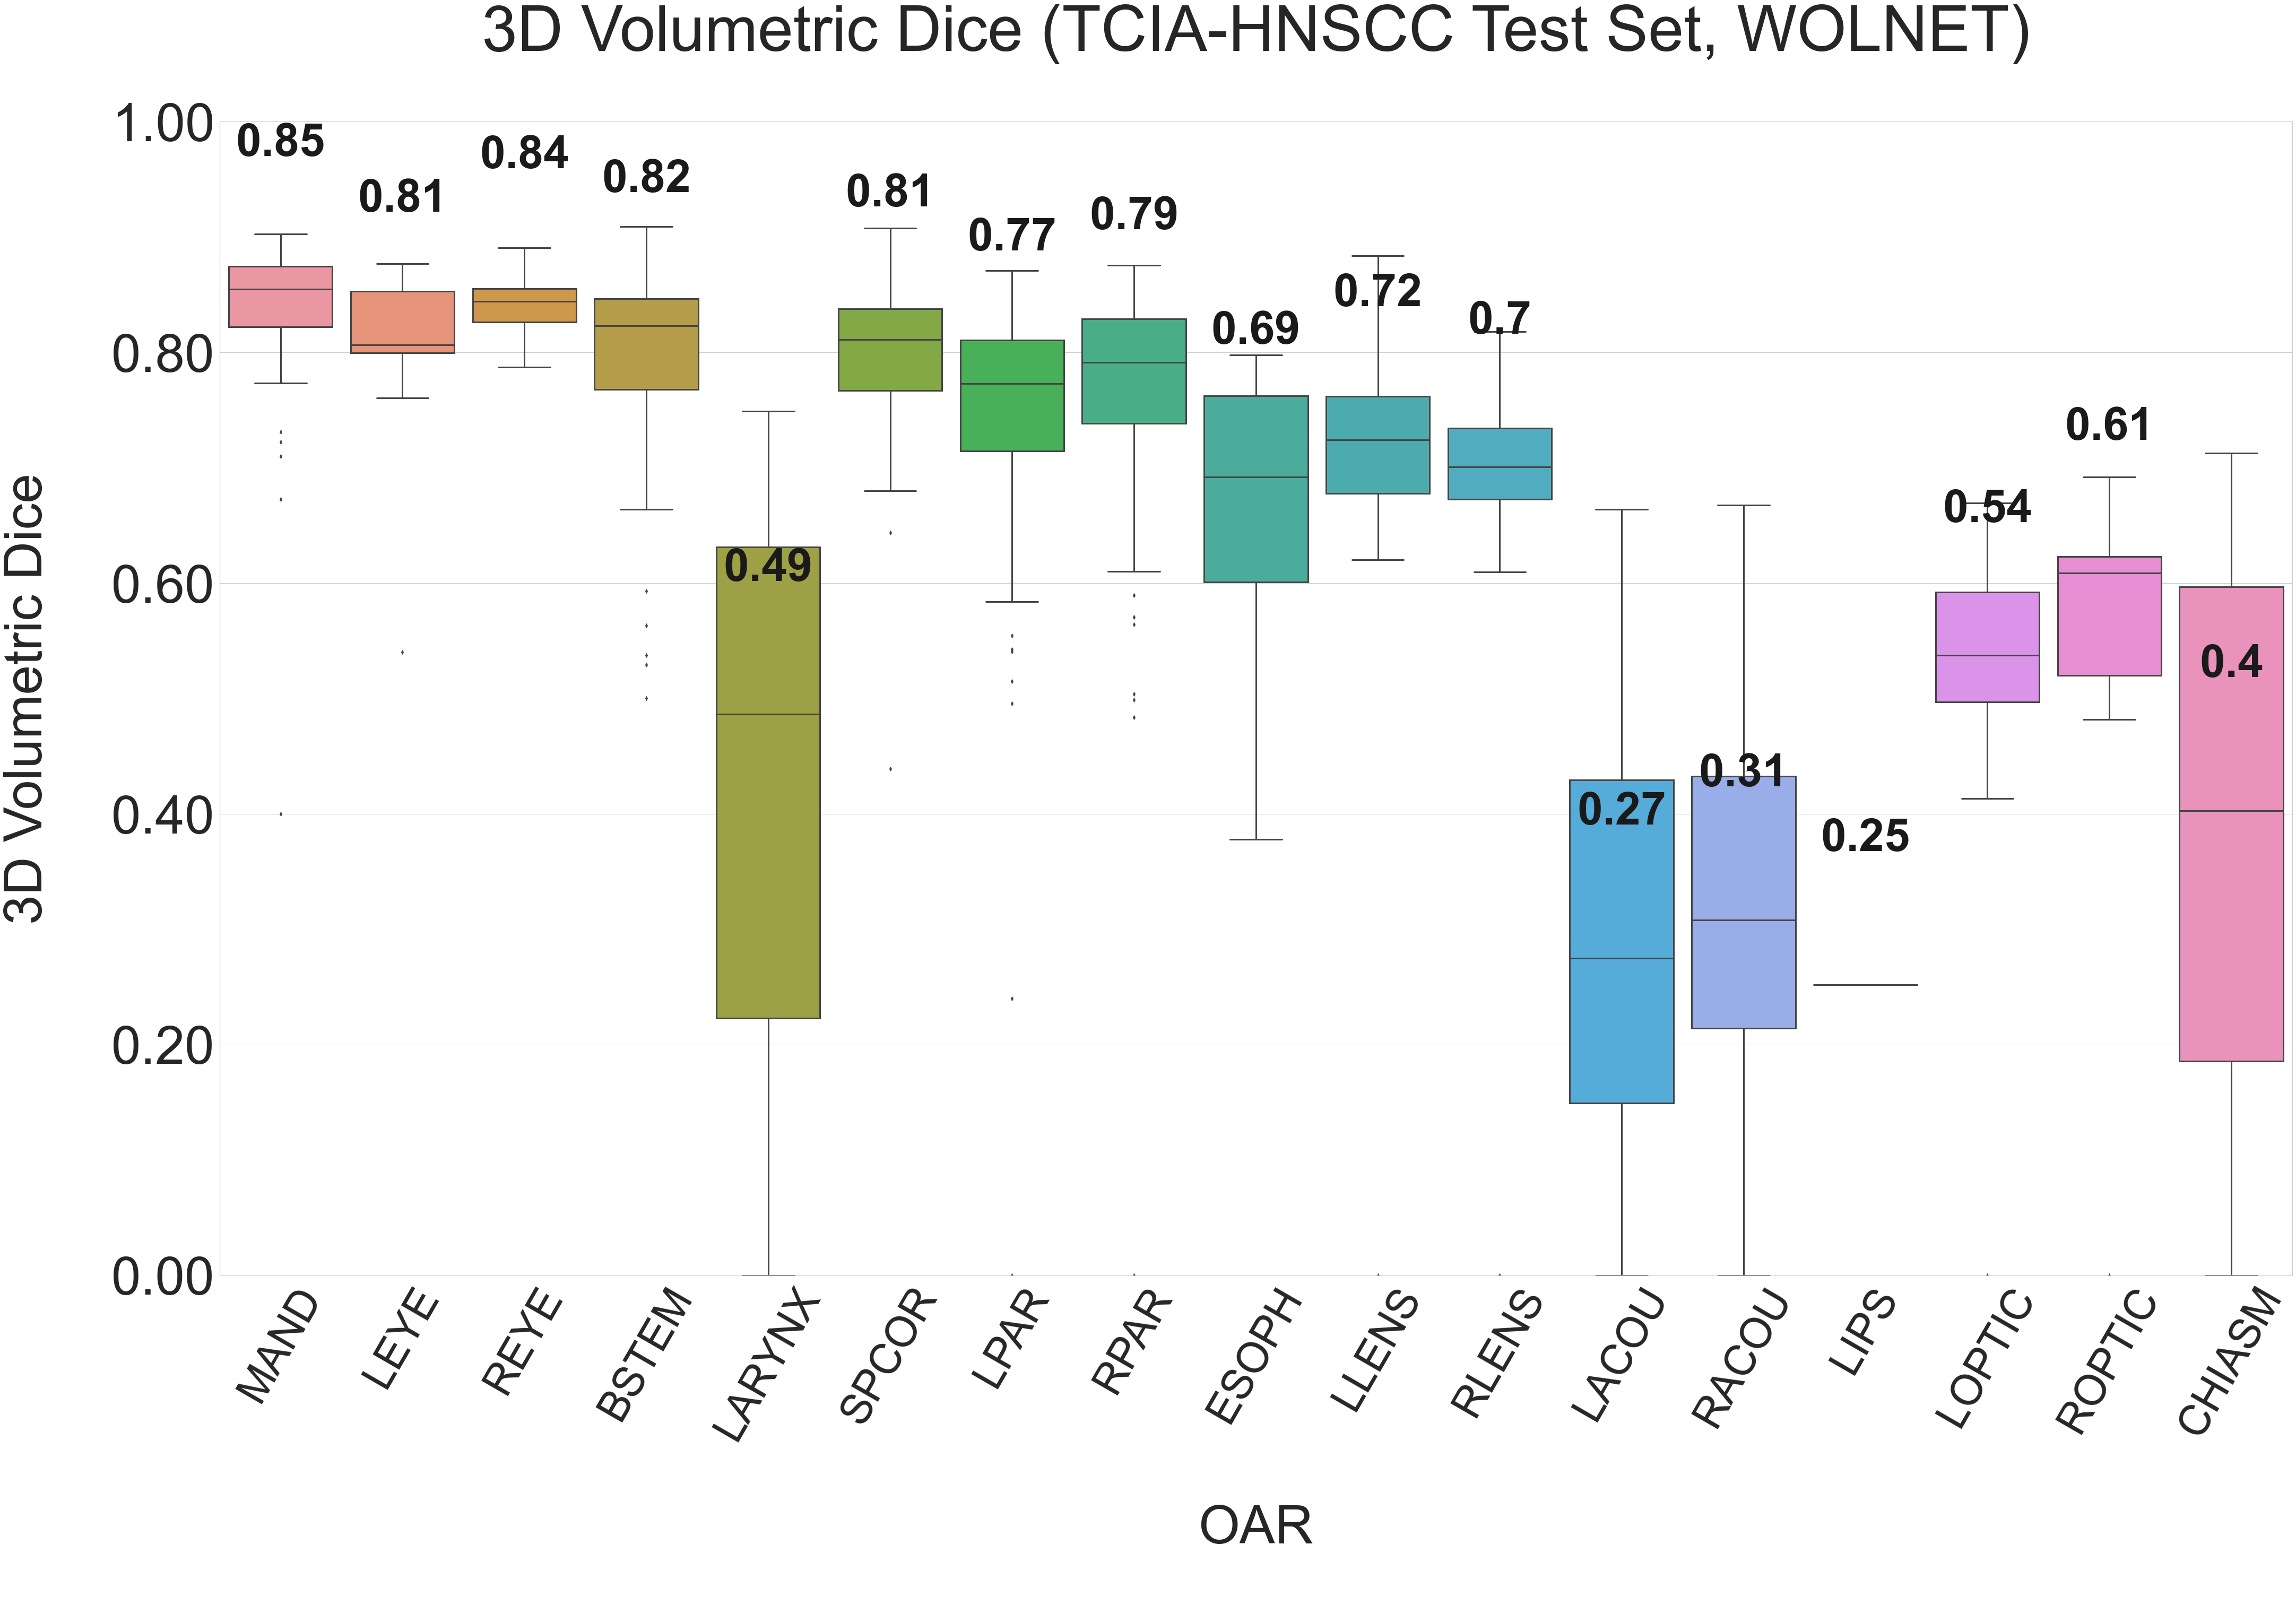

In [76]:
# NOT CORRECTED
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set1")
plt.title('3D Volumetric Dice (TCIA-HNSCC Test Set, WOLNET)\n', fontsize=120)
rois = ['MAND', 'LEYE', 'REYE', 'BSTEM', 'LARYNX', 'SPCOR', 'LPAR', 'RPAR', 'ESOPH', 'LLENS', 'RLENS', 'LACOU', 'RACOU','LIPS', 'LOPTIC', 'ROPTIC', 'CHIASM']
data_.OAR = data_.OAR.astype("category")
data_.OAR.cat.set_categories(rois, inplace=True)
data_.sort_values(["OAR"])
medians = data_.groupby(['OAR'])['VolDice'].median()
vertical_offset = data_['VolDice'].median() * 0.15 # offset from median for display
ax = sea.boxplot(data=data_, x="OAR", y="VolDice", hue="OAR", hue_order=rois, width=.85, linewidth=3,  dodge=False) # hue_order=chosen,
ax.set_ylim(0,1)
ax.set_yticklabels(ax.get_yticks(), size = 100)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
ylabels = ['{:,.2f}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='3D Volumetric Dice\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('3D Volumetric Dice\n', fontsize=100)
ax.legend_.remove()

In [79]:
# data_ = data_[data_["95HD"]<17.5]

/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_2198/3143819373.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size = 100)
/var/folders/4n/x4ks02rx2g9925jn6xb07jkw0000gn/T/ipykernel_2198/3143819373.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


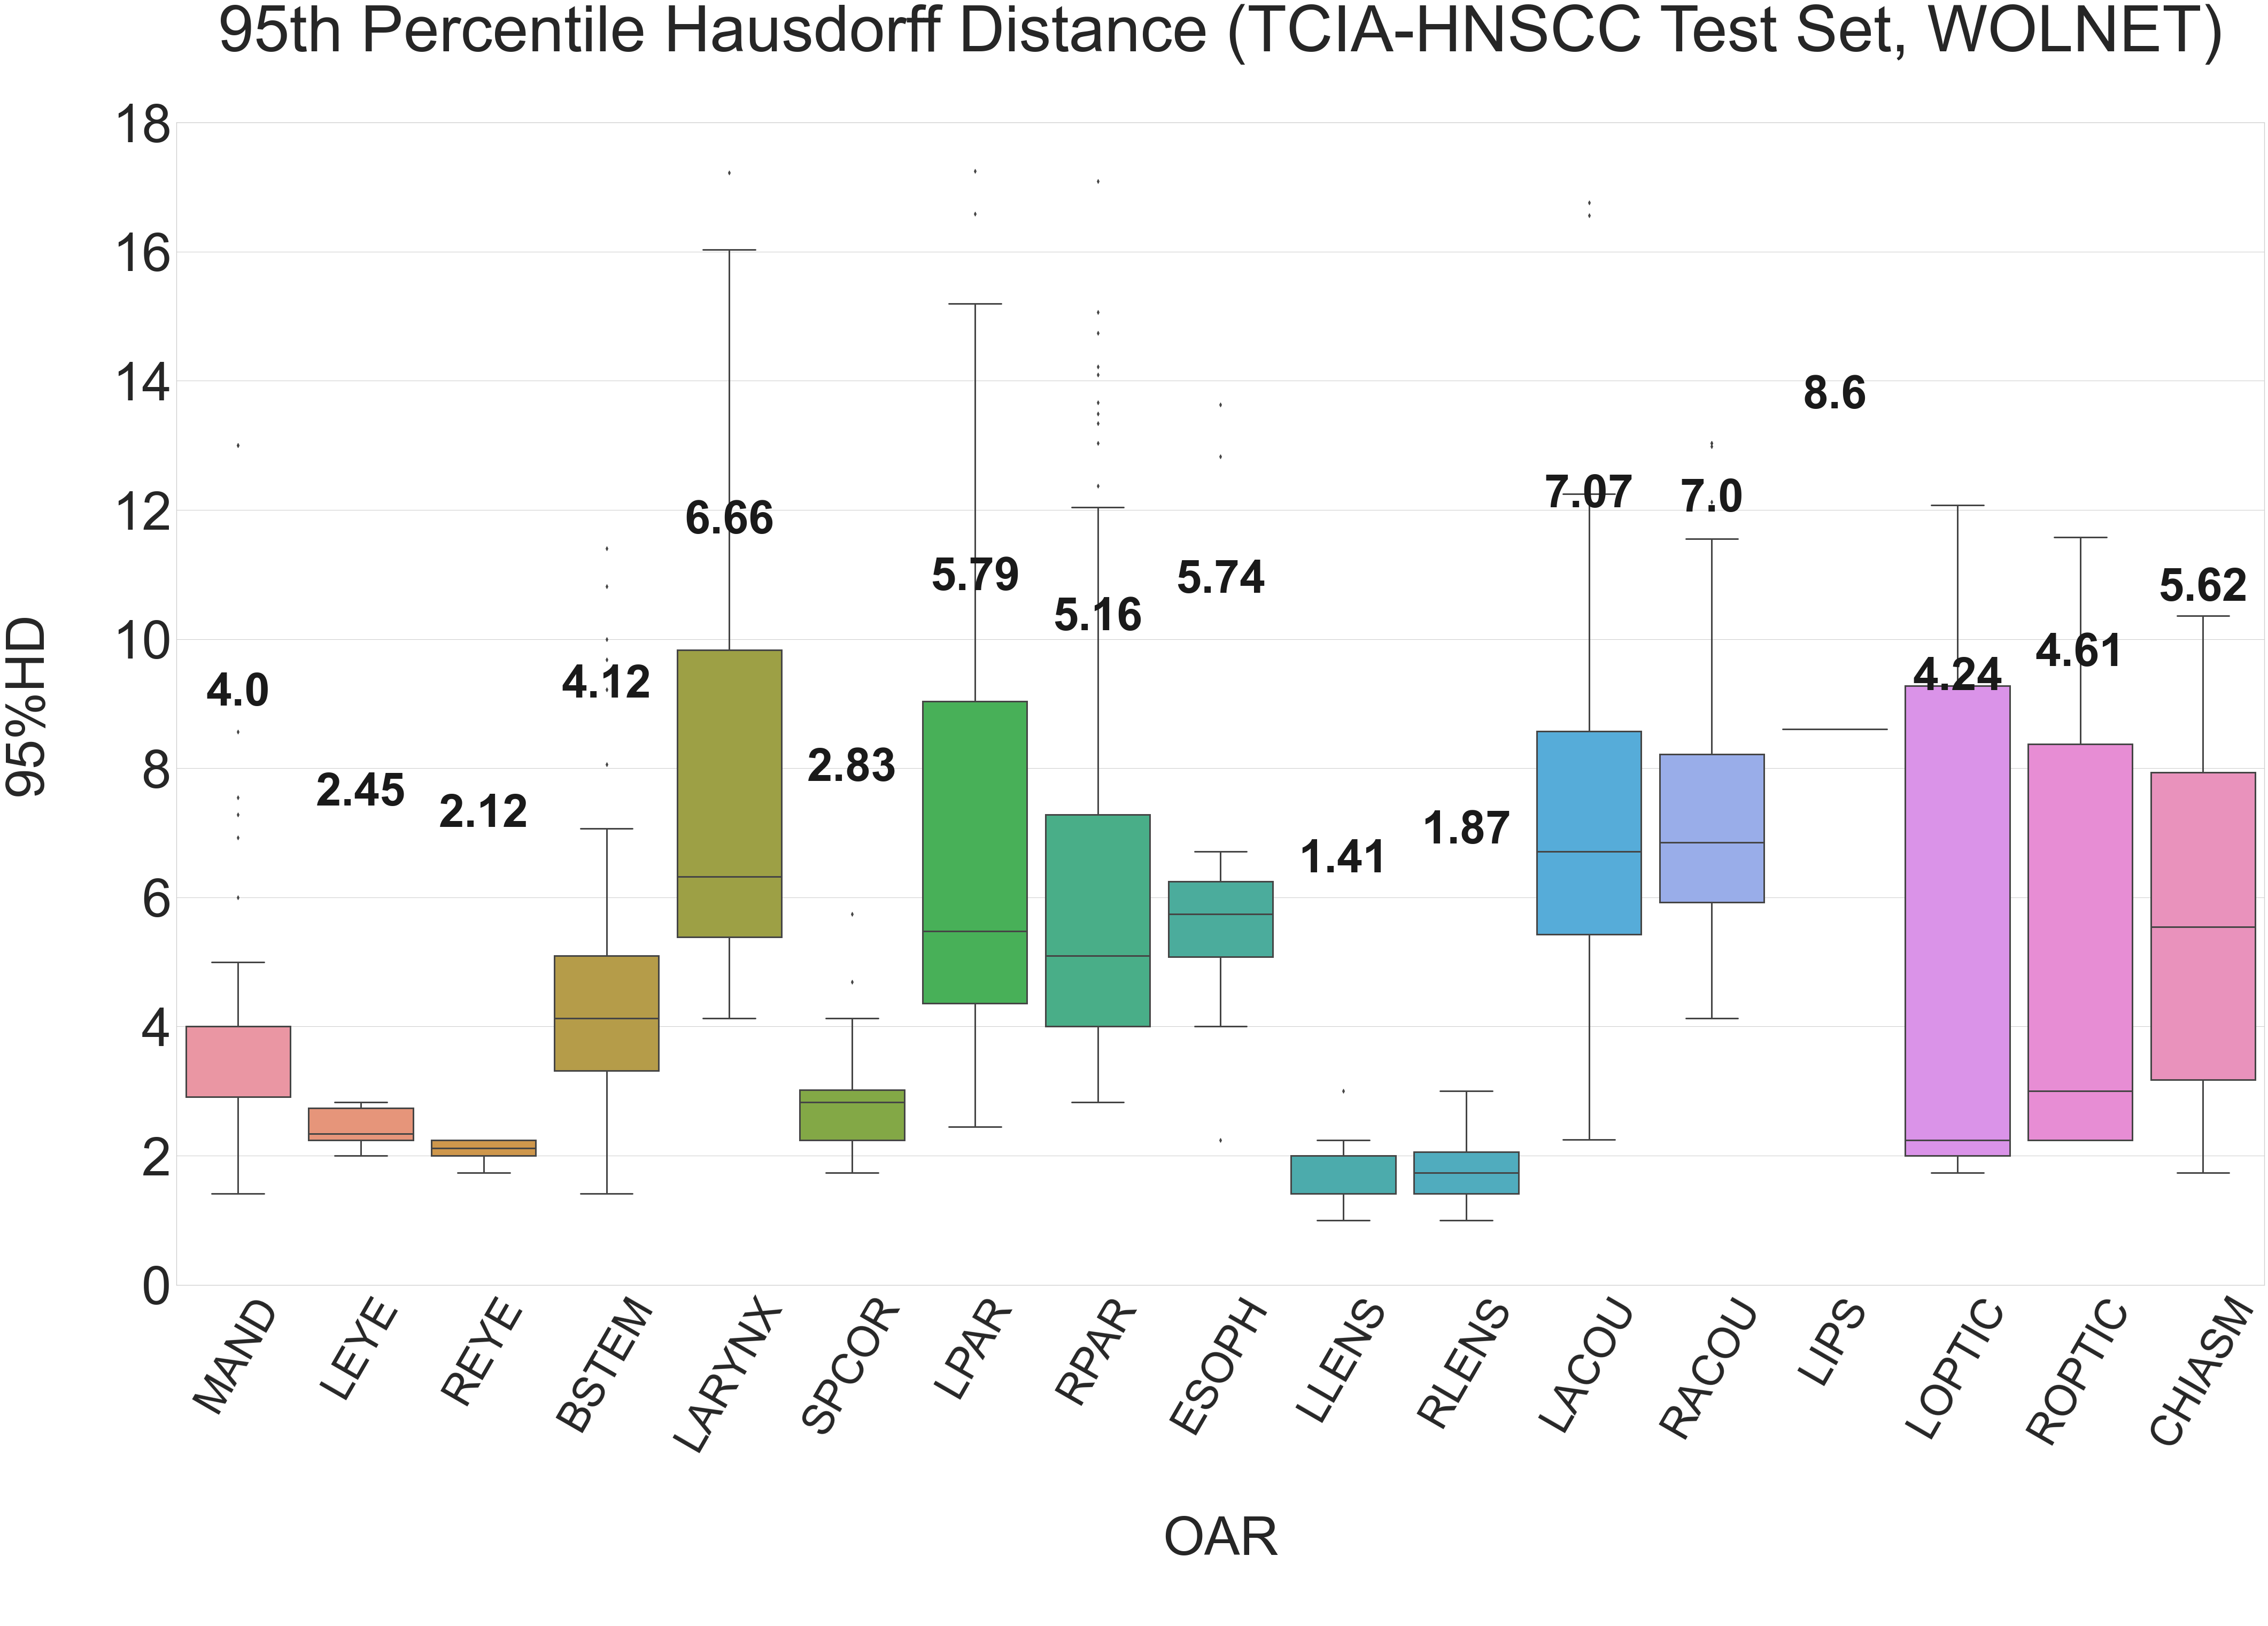

In [77]:
plt.figure(figsize=(70,40))
sea.set(font_scale=5)  # crazy big
sea.set_style("whitegrid")
sea.color_palette("Set2")
plt.title('95th Percentile Hausdorff Distance (TCIA-HNSCC Test Set, WOLNET)\n', fontsize=120)
ax = sea.boxplot(data=data_[data_["95HD"]<17.5], x="OAR", y="95HD", hue="OAR",hue_order=rois, width=.85, linewidth=3, dodge=False)
ax.set_ylim(0,18)
ax.set_yticklabels(ax.get_yticks(), size = 100)
ax.set_xticklabels(rois, rotation=60, fontsize=80)
ylabels = ['{:,.0f}'.format(x) for x in ax.get_yticks()]
ax.set_yticklabels(ylabels)
medians = data_.groupby(['OAR'])['95HD'].median()
vertical_offset = data_['95HD'].median() * 1.1 # offset from median for display
for xtick in ax.get_xticks():
    ax.text(xtick,medians[xtick] + vertical_offset, np.round(medians[xtick],2), 
            horizontalalignment='center',size='x-large',color='k',weight='semibold')
# ax.set(xlabel='\nOAR\n', ylabel='95%HD\n')
ax.set_xlabel('\nOAR\n', fontsize=100)
ax.set_ylabel('95%HD\n', fontsize=100)
ax.legend_.remove()

In [19]:
reference.iloc[100]

CT          /cluster/projects/radiomics/PublicDatasets/Hea...
RTSTRUCT    /cluster/projects/radiomics/PublicDatasets/Hea...
ID                                            HNSCC-01-0389_0
Name: 100, dtype: object

In [15]:
# deep_classes = ['Brainstem','Lens-Lt', 'Lens-Rt', 'Mandible', 'Optic-Nerve-Lt', 'Optic-Nerve-Rt', 'Parotid-Lt', 'Parotid-Rt', 'Orbit-Lt', 'Orbit-Rt', 'Spinal-Cord', 'Spinal-Canal']
# deep_classes2 = ['Brainstem','Lens_Lt', 'Lens_Rt', 'Mandible', 'Optic_Nerve_Lt', 'Optic_Nerve_Rt', 'Parotid_Lt', 'Parotid_Rt', 'Orbit_Lt', 'Orbit_Rt', 'Spinal_Cord', 'Spinal_Canal']
index_ = [1, 12, 13, 5, 16, 17, 6, 7, 14, 15, 2, 2]
chosen = ['BSTEM','SPCOR','ESOPH','LARYNX','MAND','LPAR','RPAR','LACOU','RACOU','RPLEX','LPLEX','LLENS','RLENS','LEYE','REYE','LOPTIC','ROPTIC','CHIASM','LIPS']

In [42]:
im=nrrd.read(dat[dat['Include']==False].iloc[0]['Path'])

In [65]:
example = sitk.ReadImage('/Users/joemarsilla/Downloads/ProcessedDatasets/HeadNeck/TCIA_HNSCC/HNSCC-01-0001_0/CT_IMAGE.nrrd')

In [66]:
reader = sitk.ImageFileReader()
reader.SetFileName('/Users/joemarsilla/Downloads/ProcessedDatasets/HeadNeck/TCIA_HNSCC/HNSCC-01-0001_0/CT_IMAGE.nrrd')
reader.LoadPrivateTagsOn()
reader.ReadImageInformation()

In [67]:
# create dictionary
v = {}
for k in reader.GetMetaDataKeys():
    v[k] = reader.GetMetaData(k)

In [68]:
v['Spacing'] = reader.GetSpacing()
v['Origin'] = reader.GetOrigin()
v['GetDirection']=reader.GetDirection()
v['Size']=reader.GetSize()

In [69]:
v

{'ITK_InputFilterName': 'NrrdImageIO',
 'NRRD_kinds[0]': 'domain',
 'NRRD_kinds[1]': 'domain',
 'NRRD_kinds[2]': 'domain',
 'NRRD_space': 'left-posterior-superior',
 'Spacing': (0.9375, 0.9375, 2.5),
 'Origin': (0.0, 0.0, -1466.3699951171875),
 'GetDirection': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0),
 'Size': (512, 512, 117)}

In [70]:
a = sitk.GetArrayFromImage(example)
nrrd.write('/Users/joemarsilla/Downloads/ProcessedDatasets/HeadNeck/TCIA_HNSCC/HNSCC-01-0001_0/ct_img_test.nrrd',a,header=v)

In [61]:
reader.GetSpacing()
reader.GetOrigin()
reader.GetDirection()
reader.GetNumberOfComponents() 

1

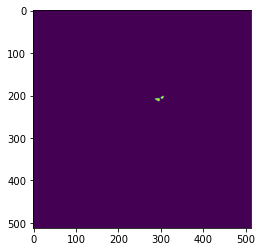

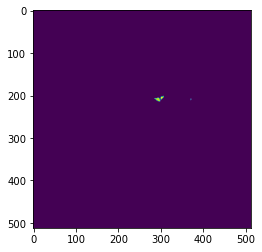

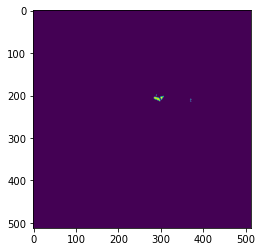

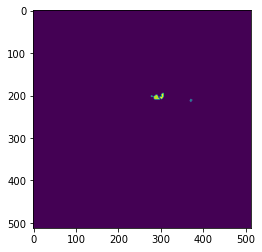

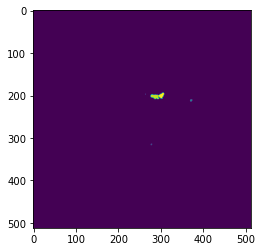

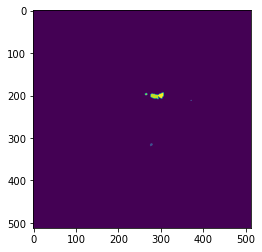

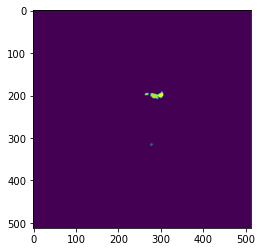

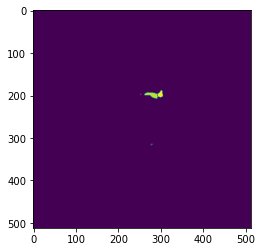

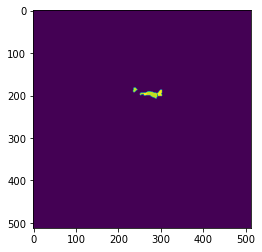

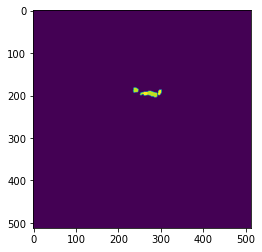

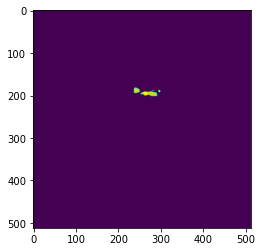

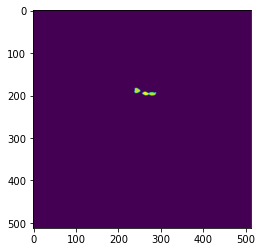

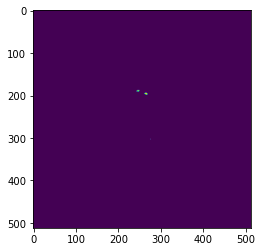

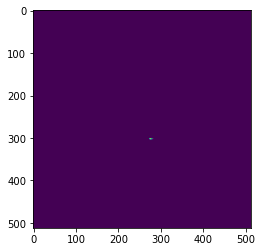

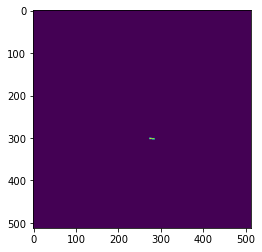

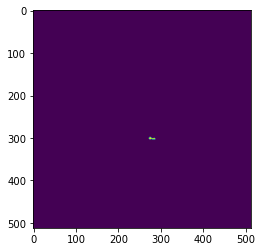

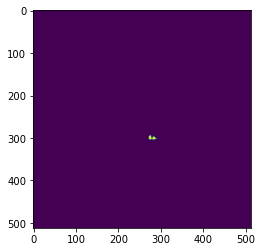

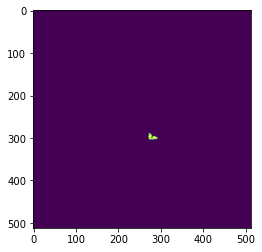

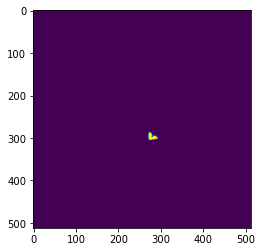

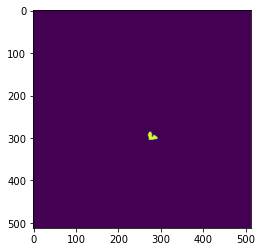

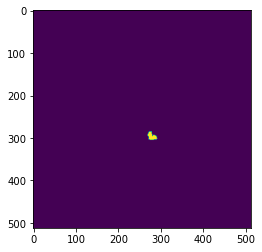

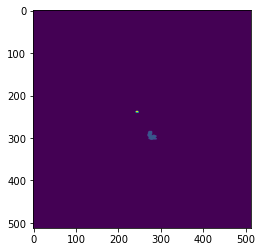

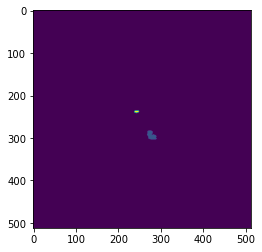

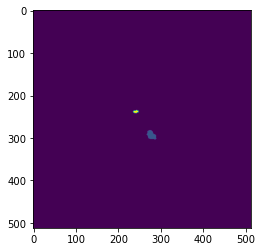

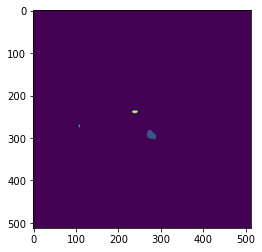

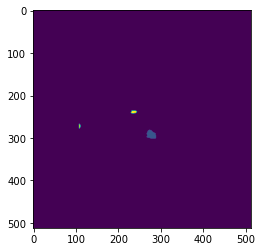

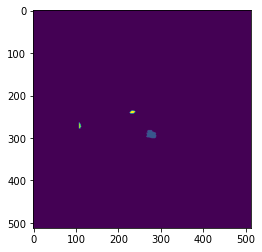

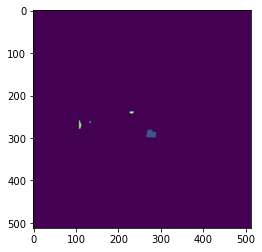

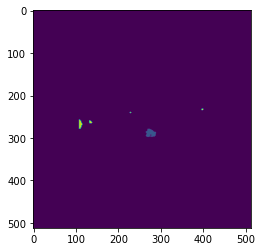

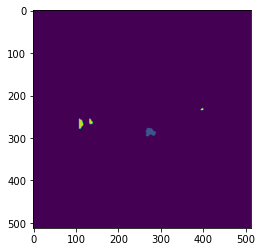

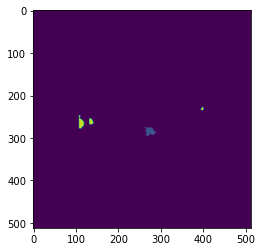

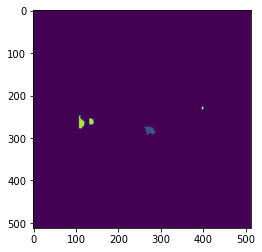

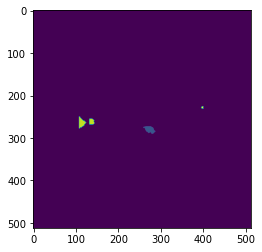

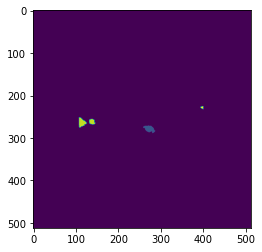

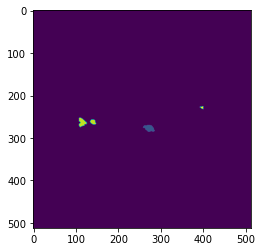

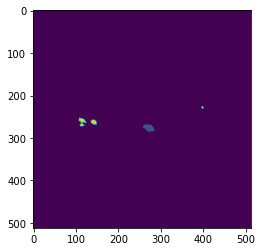

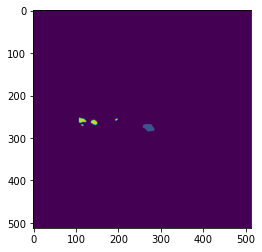

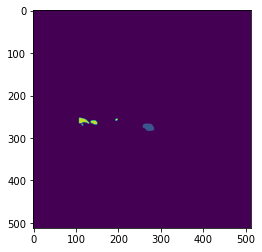

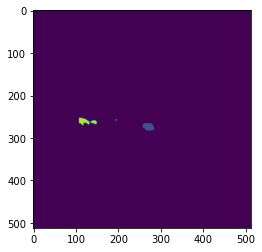

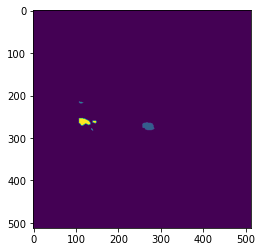

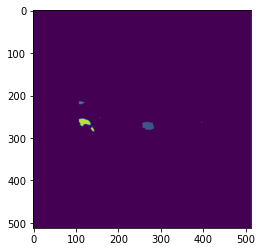

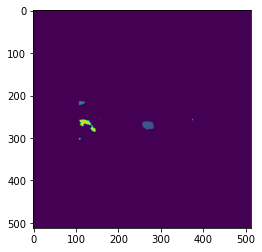

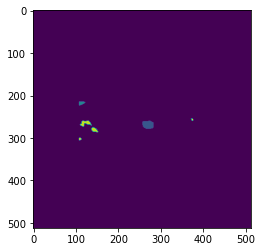

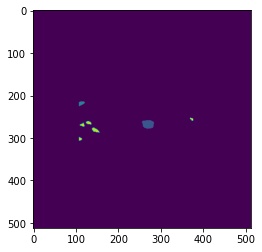

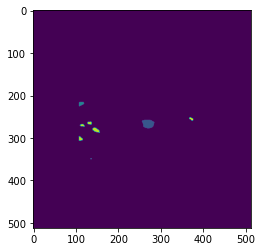

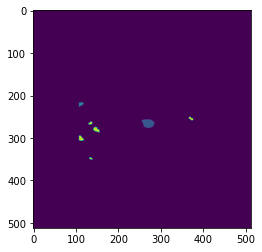

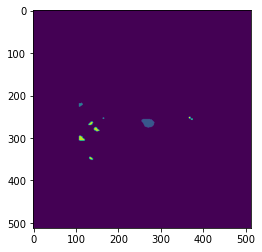

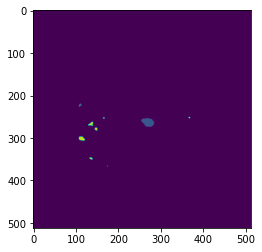

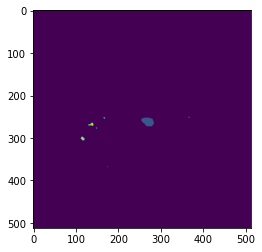

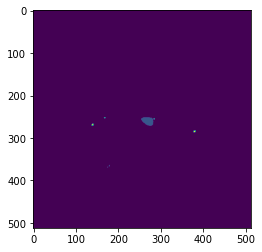

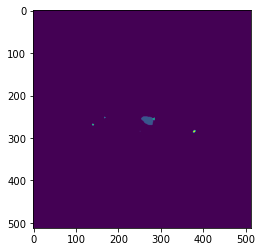

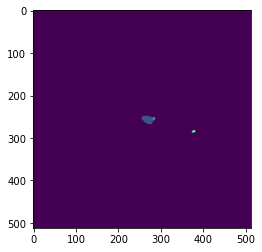

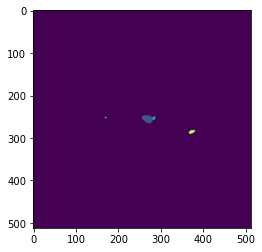

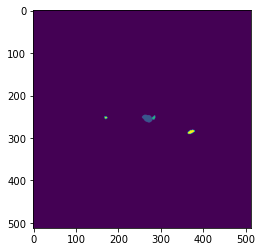

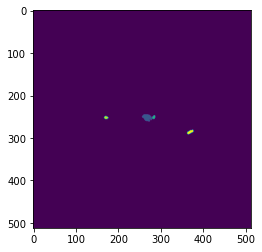

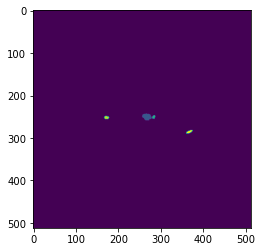

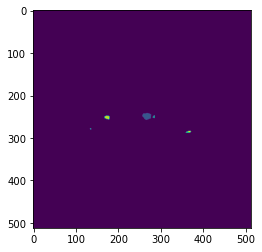

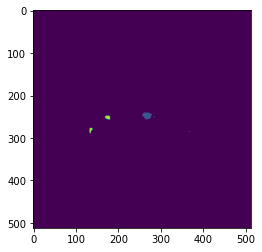

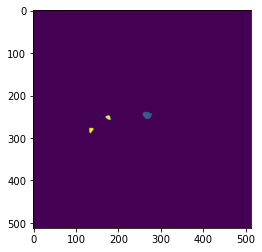

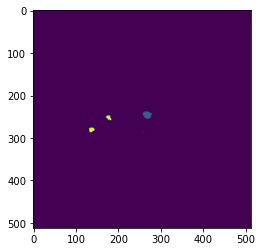

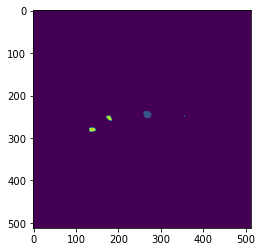

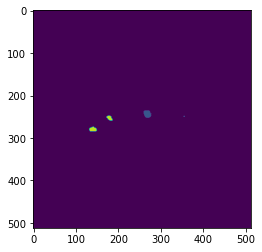

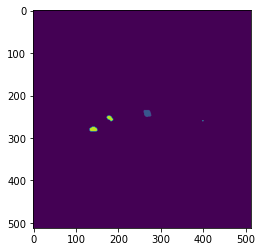

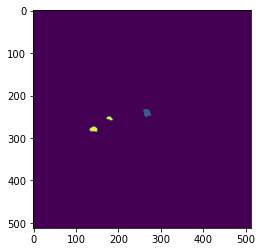

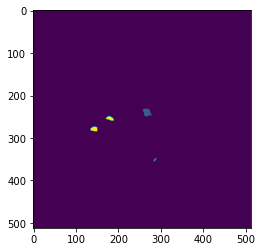

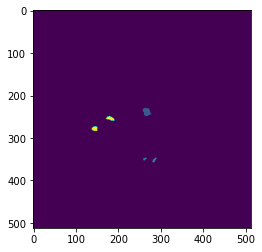

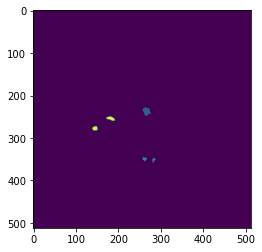

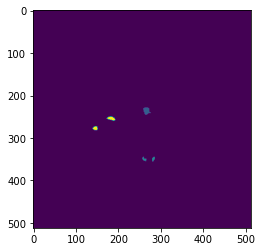

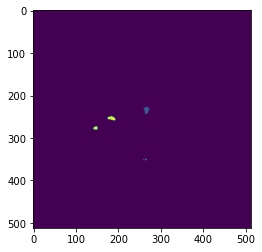

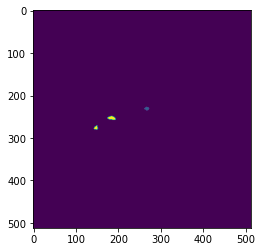

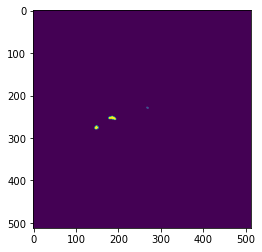

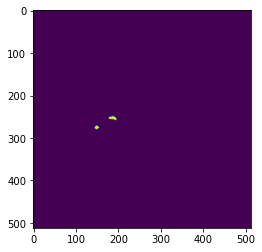

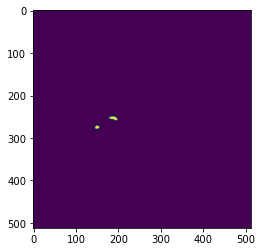

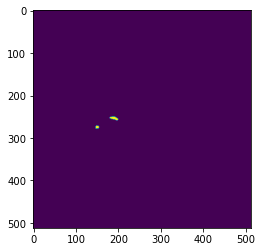

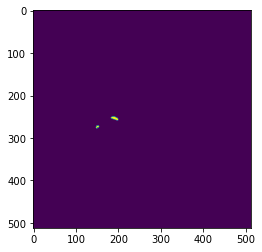

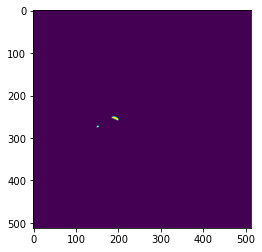

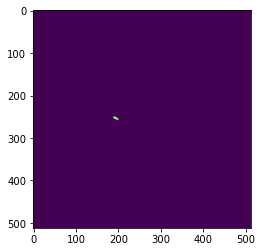

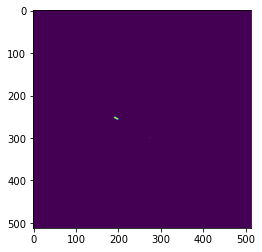

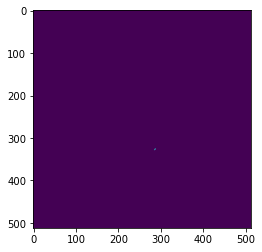

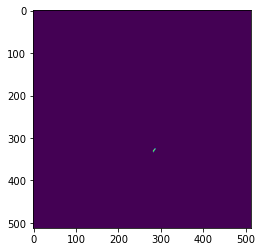

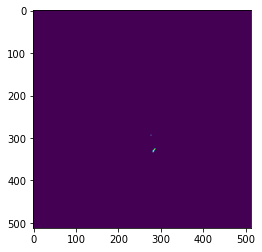

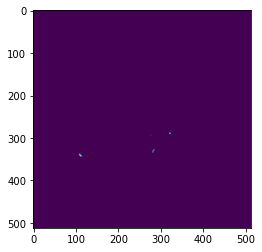

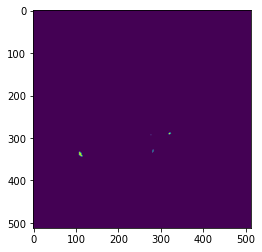

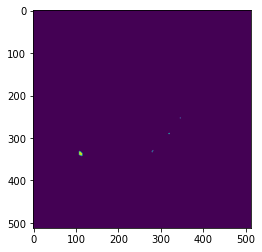

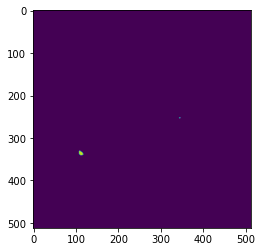

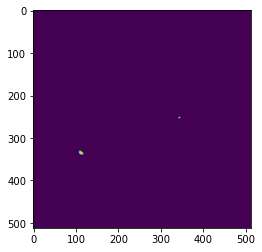

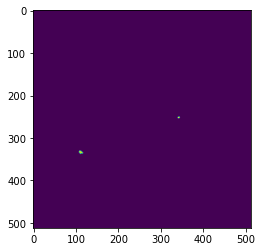

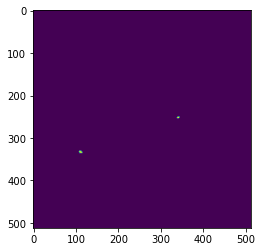

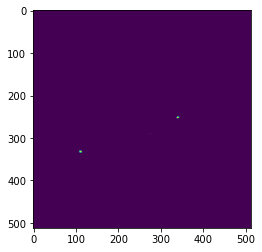

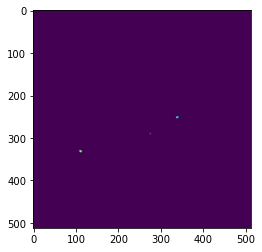

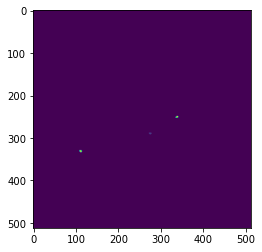

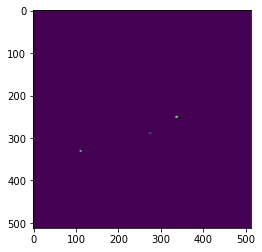

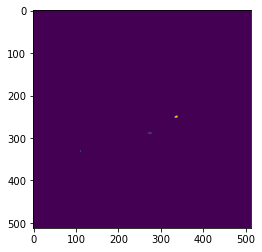

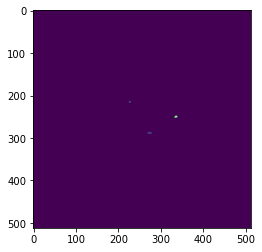

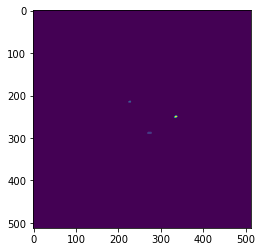

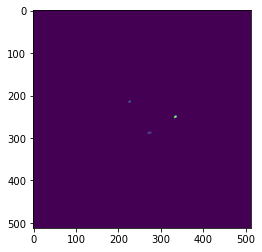

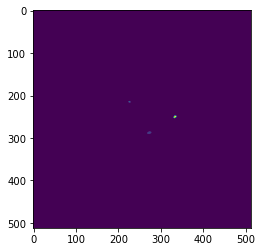

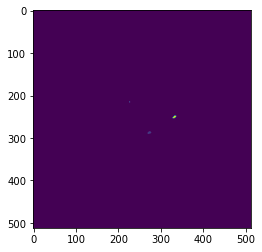

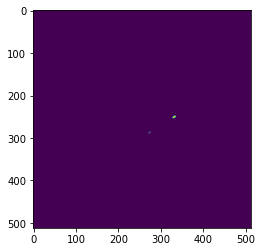

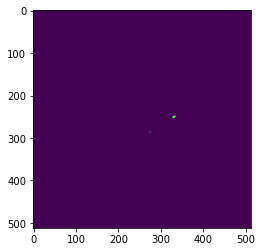

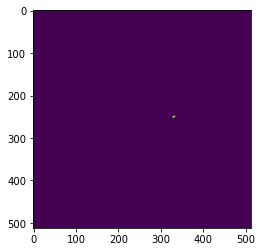

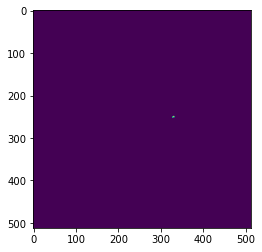

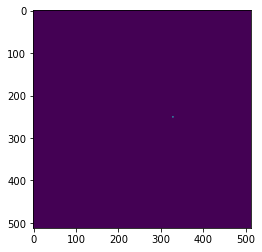

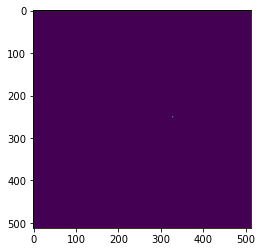

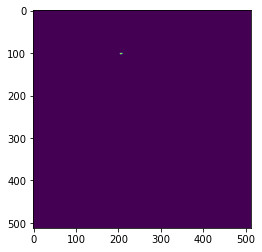

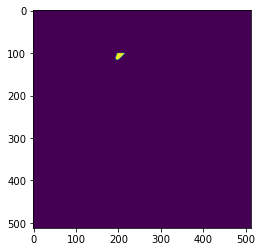

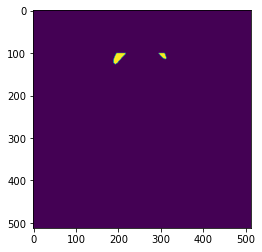

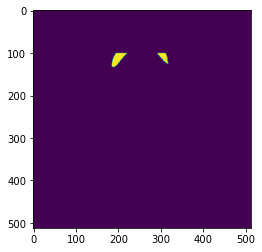

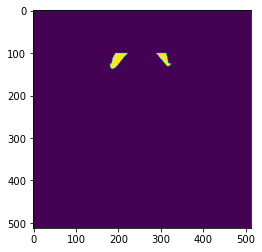

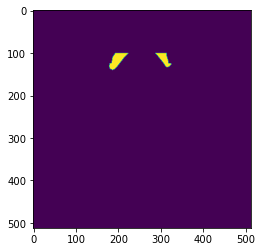

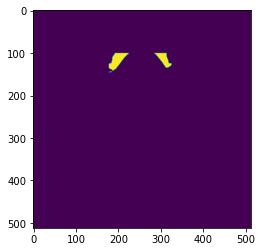

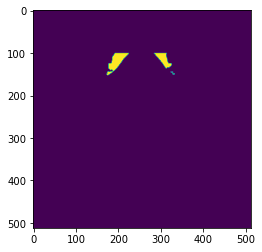

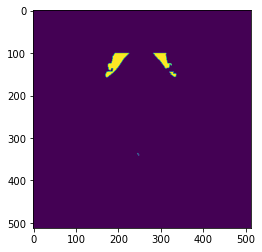

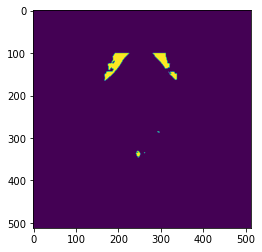

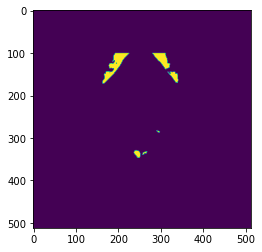

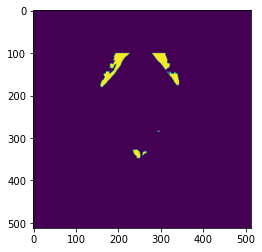

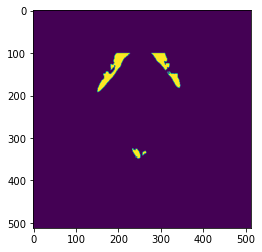

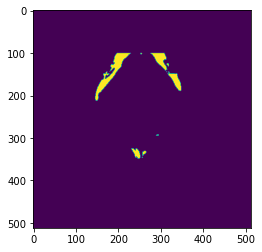

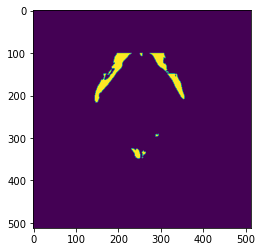

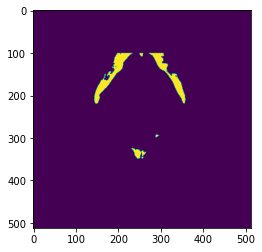

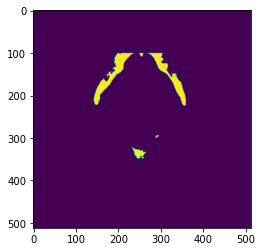

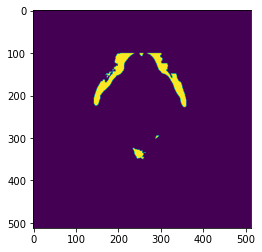

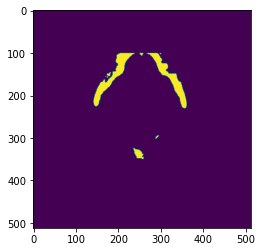

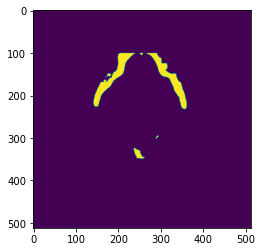

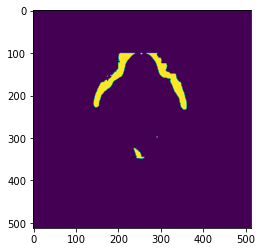

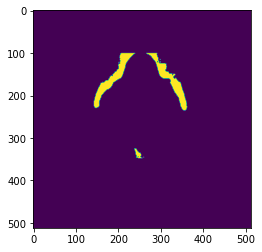

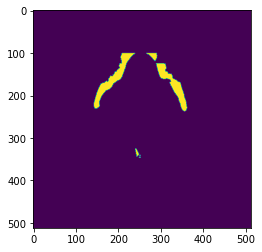

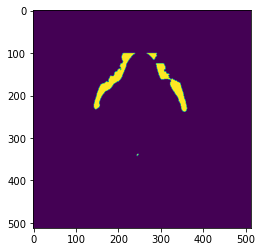

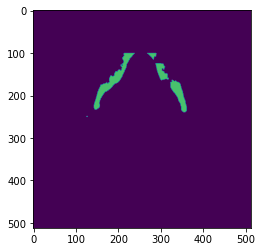

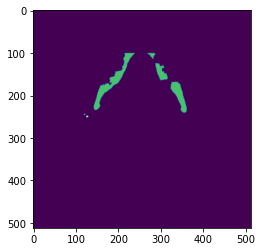

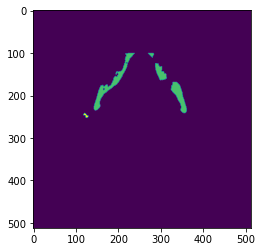

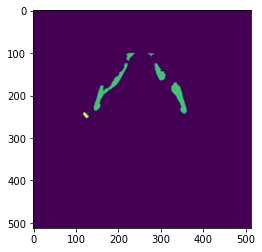

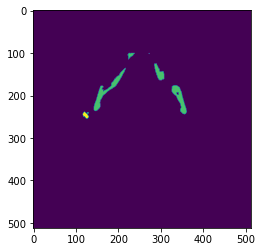

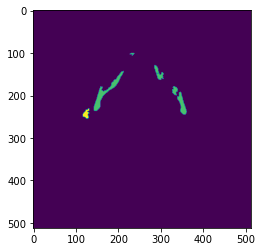

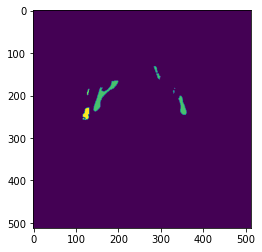

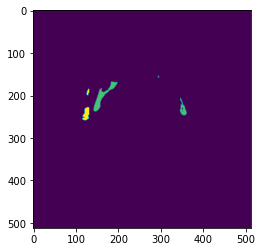

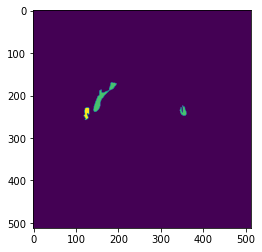

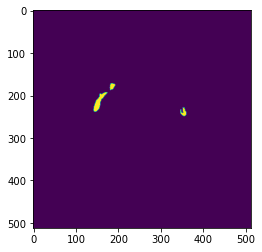

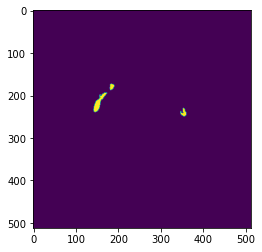

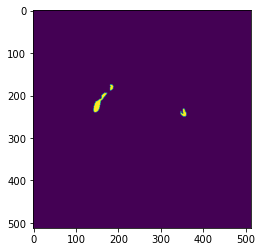

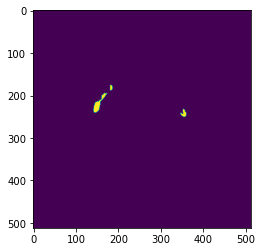

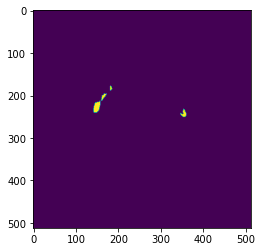

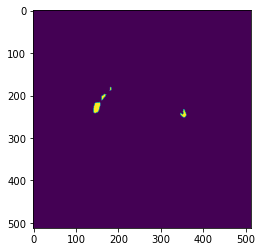

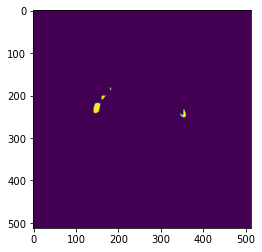

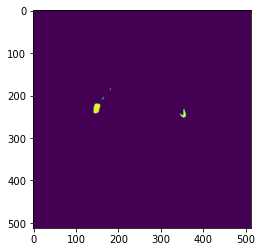

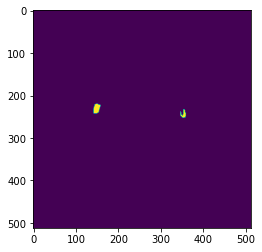

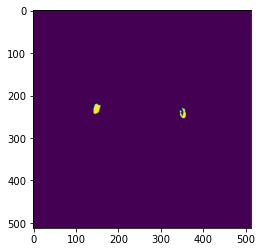

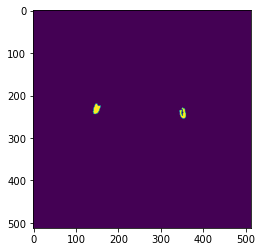

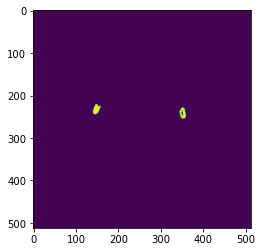

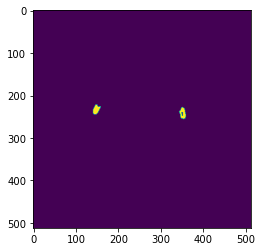

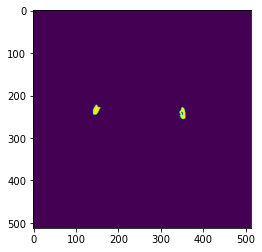

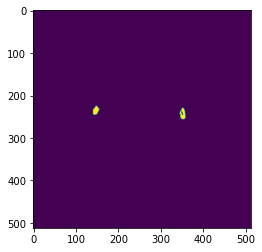

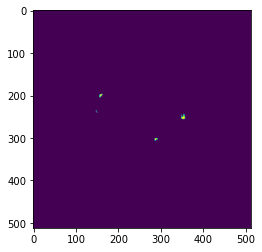

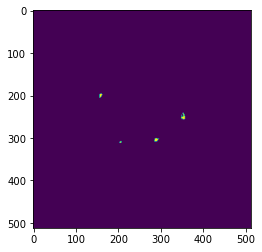

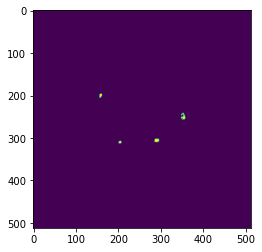

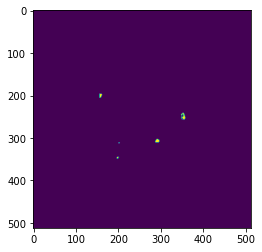

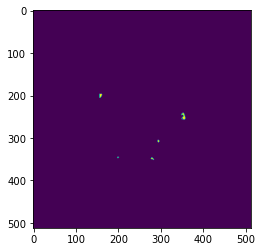

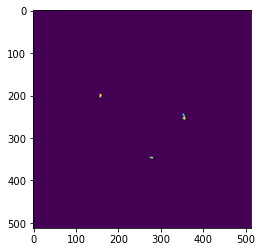

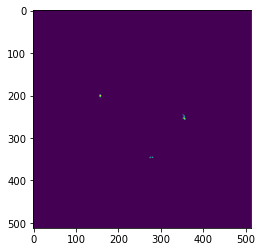

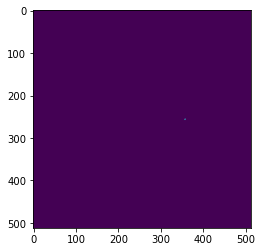

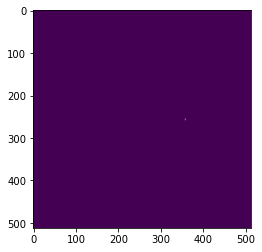

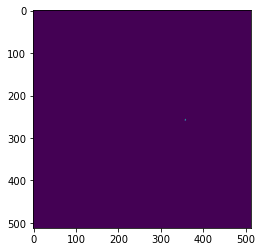

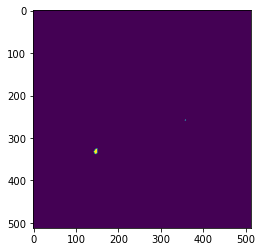

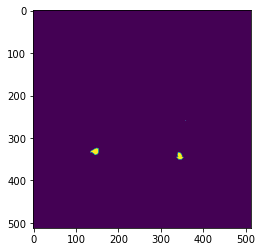

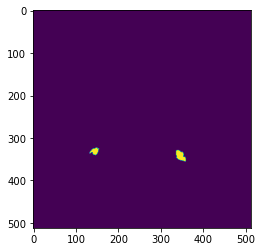

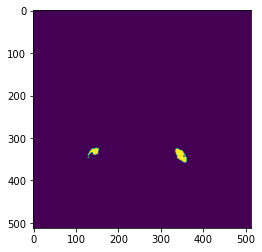

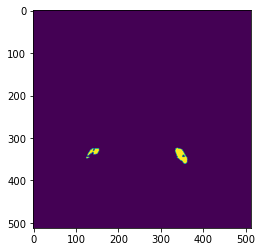

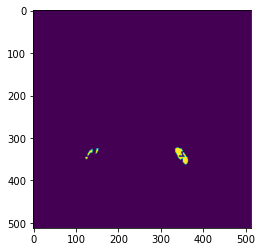

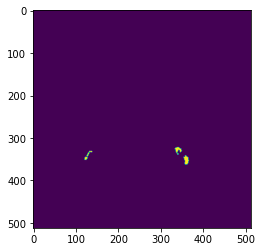

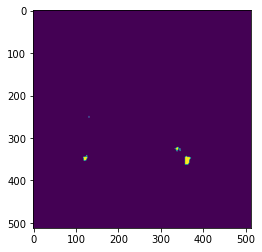

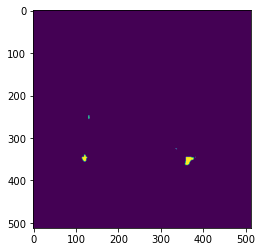

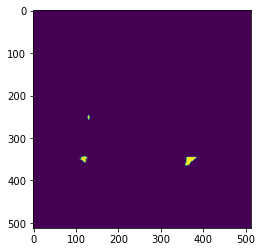

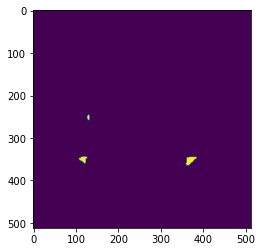

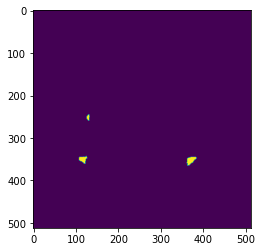

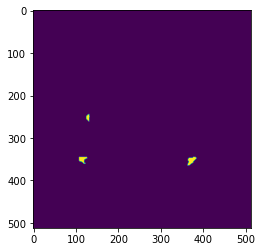

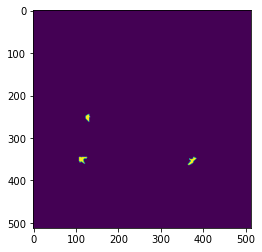

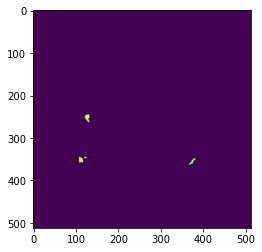

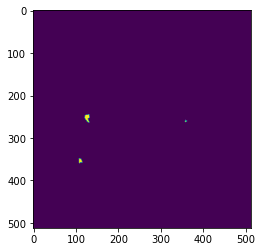

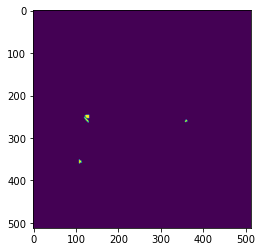

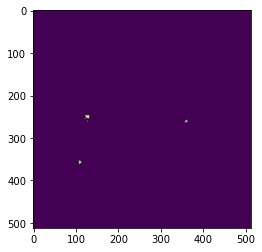

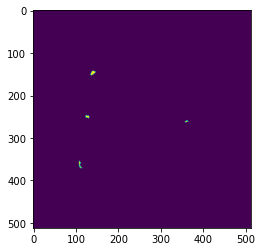

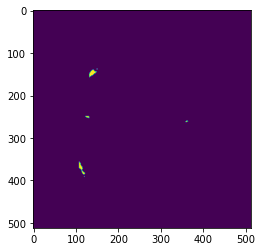

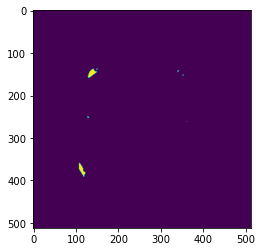

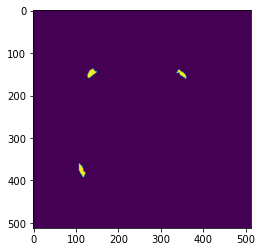

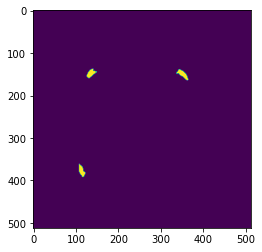

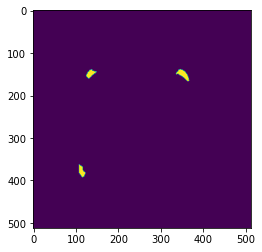

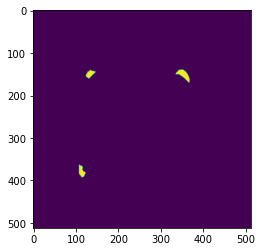

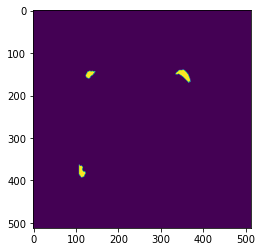

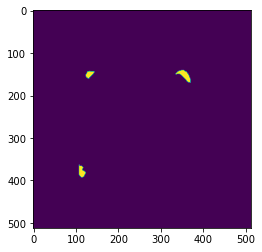

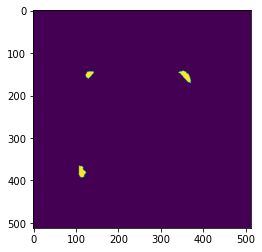

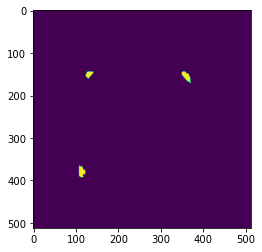

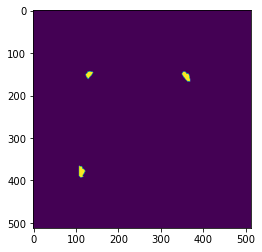

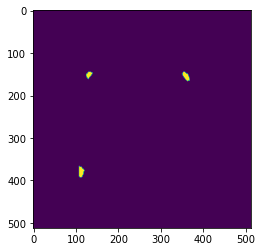

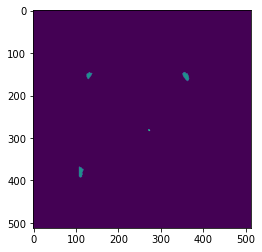

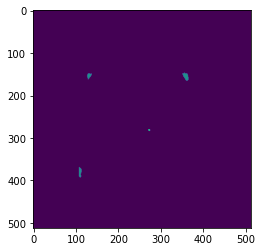

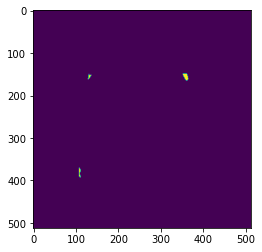

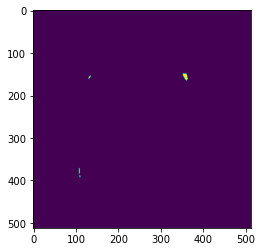

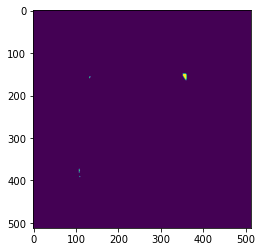

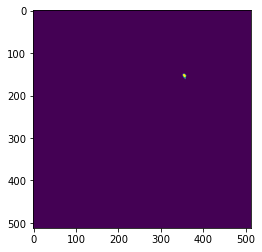

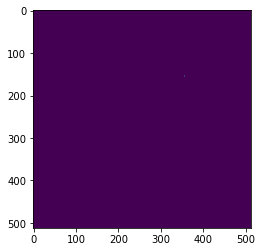

In [43]:
# show that predictions are quite (not good)
for i, slice_ in enumerate(im[0]):
    if slice_.max()>0:
        plt.imshow(slice_)
        plt.show()